In [1]:
import qctoolkit as qtk # https://github.com/SamKChang/qctoolkit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import os
import ast

plt.style.use('classic')

%matplotlib inline

In [2]:
gaas = qtk.QMOut('gaas_ref/gaas_ref.out', program='abinit')
alas = qtk.QMOut('gaas_rst_test/gaas_rst_test.out', program='abinit')
#opt_log = qtk.Logger('optimization/algaas_444.db')
opt_log = qtk.Logger('optimization/algaas_444.db')
entries = [e for e in opt_log.list(has_data=True) if e.data > 0]

def extract(i):
    
    def getOut(out_path):
        out = None
        if os.path.exists(out_path):
            out_file = glob.glob("%s/*.out" % out_path)[0]
            out = qtk.QMOut(out_file, program='abinit')
            return out
    
    out = None
    if i < len(entries):
        entry = entries[i]
        if 'processing' not in entry.comment:
            try:
                out_root = entry.comment.split("'")[1]
            except IndexError:
                out_root = entry.comment

            out_path = 'optimization/results/step01/%s' % out_root
            out_true = 'true_remote/step01/%s' % out_root
            
            #out_path = 'optimization/results/%s' % out_root
            #out_true = 'true_remote/%s' % out_root
            
    return getOut(out_path), getOut(out_true)

more than one o_EIG files found loading last file with name: gaas_ref/gaas_refo_DS2_EIG
occupation number not available... try to use molecule object with closed shell assumption
DB: loading existing database: optimization/algaas_444.db 


/home/samio/src/science/qctoolkit/qctoolkit/utilities/tools.py:87: RuntimeWarning: invalid value encountered in sqrt
  sc = np.sqrt(1-cc**2) # sin(gamma) = sqrt(1-cos(gamma)^2)


occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
more than one o_EIG files found loading last file with name: true_remote/alchemy-o_0411011630_830/alchemy-o_0411011630_830o_DS2_EIG
occupation number not available... try to use molecule object with closed shell assumption
more than one o_EIG files found loading last file with name: true_remote/alchemy-li_0411024359_047/alchemy-li_0411024359_047o_DS2_EIG
no k-point information (o_EIG file) found
occupation number not available... try to use molecule object with closed shell assumption


(array([ 0.03880517,  0.03880517,  0.03880517, ...,  0.17121195,
         0.12441115,  0.17121195]),
 array([-12.18724962, -12.14743935, -11.82174615, ...,   2.74462305,
          2.77080041,   2.77080041]),
 array([  7.50000000e-05,   5.93500000e-03,   2.29052000e-01, ...,
          2.63800000e-03,   1.74820000e-02,   5.37900000e-03]))

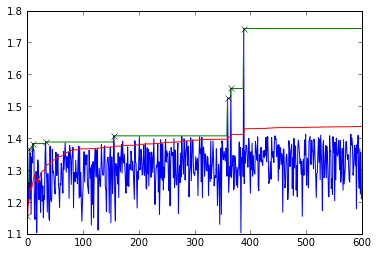

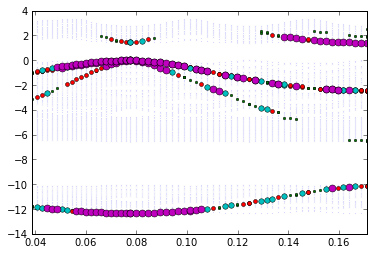

In [3]:
outs = []
outs_true = []
for i in range(len(entries)):
    out, out_true = extract(i)
    if out:
        outs.append(out) 
        outs_true.append(out_true)
        
Eg_list = [e.data for e in entries]

max_list = []
max_x = []
max_y = []
itr = 0
avg_list = []
for i in range(len(Eg_list)):
    Eg = Eg_list[i]
    if len(max_list) == 0 or Eg >= max(max_list):
        max_list.append(Eg)
        max_x.append(i)
        max_y.append(Eg)
    else:
        max_list.append(max_list[-1])
    if i > 0:
        limit = min(i, 20)
        avg_entries = np.array(sorted(Eg_list[:i])[::-1][:limit])
        avg_list.append(avg_entries.mean())
    else:
        avg_list.append(Eg)
        

plt.plot(Eg_list)
plt.plot(max_list)
plt.plot(avg_list)
plt.plot(max_x, max_y, ls='', marker='x', mec='k')
outs[0].plot_band_unfold([[0.5,0,0.25],[0,0,0],[0,0.5,0.5]], [4,4,4], zero_weight_color='0.99')

In [4]:
def stepPlot(ax, ticksize=None, labelsize=None, legendsize=None, search_color='b', avg_color='g', ls = ':'):
    ax.plot(Eg_list, marker ='x', ls=ls, color=search_color, label='searched crystals', mec=search_color)
    ax.plot(max_list, color='k', lw=2)
    ax.step(max_x, max_y, where='post', 
             color='k', lw=2, marker='x', 
             markersize=10, mew=3, 
             label='best in population')
    ax.plot(avg_list, color=avg_color, lw=2, label='average of population')
    
    if labelsize:
        ax.set_xlabel('steps', fontsize=labelsize)
        ax.set_ylabel(r'$E_g$ [eV]', fontsize=labelsize)
    else:
        ax.set_xlabel('steps')
        ax.set_ylabel(r'$E_g$ [eV]')
    #ax.set_xticklabels(ax1.get_xticklabels(),fontsize=15)
    if ticksize:
        ax.set_xticklabels(range(0,len(entries),200),fontsize=ticksize)
        ax.set_yticklabels(np.arange(1, 1.7,0.1),fontsize=ticksize)
    else:
        ax.set_xticklabels(range(0,len(entries),200))
        ax.set_yticklabels(np.arange(1, 1.7,0.1))
        
    if legendsize:
        ax.legend(loc=4, fontsize=legendsize, numpoints=1)
    else:
        ax.legend(loc=4, numpoints=1)
    
    return ax

def bandPlot(ax, out, ticksize=None, labelsize=None, legendsize=None, zero_weight_color='k'):
    tick_pos = [0.031, 0.079, 0.173]
    tick_txt = [
        r'$\mathrm{L}$', r'$\Gamma$', r'$\mathrm{X}$'
    ]
    out.plot_band_unfold([[0.5,0,0.25],[0,0,0],[0,0.5,0.5]], [4,4,4], 
                         ax=ax, zero_weight_color=zero_weight_color)
    ax.set_xticks(tick_pos)
    if ticksize:
        ax.set_xticklabels(tick_txt, fontsize=ticksize)
        ax.set_yticklabels(np.arange(-14,5,2), fontsize=ticksize)
    else:
        ax.set_xticklabels(tick_txt)
        ax.set_yticklabels(np.arange(-14,5,2))
    if labelsize:
        ax.set_xlabel(r'wavevector $\mathbf{k}$', fontsize=labelsize)
        ax.set_ylabel(r'$E(\mathbf{k})$ [eV]', fontsize=labelsize)
    else:
        ax.set_xlabel(r'wavevector $\mathbf{k}$')
        ax.set_ylabel(r'$E(\mathbf{k})$ [eV]')
    
    return ax

In [5]:
outs

[nan, nan, nan, nan, nan]

In [11]:
def version1():
    
    out = outs[3]
    print out.name, out.Eg
    
    nAl = float(out.molecule.name.split('Ga')[0].replace('Al',''))
    ratio = "%5.3f" % (nAl / 64)
    Eg = "%5.3f" % out.Eg

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

    ax1 = stepPlot(ax1,ticksize=15, labelsize=20, legendsize=20)
    ax2 = bandPlot(ax2, out,ticksize=15, labelsize=20, legendsize=20)

    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.text(0.035, 3.4, 
             r'Band structure of Al$_x$Ga$_{1-x}$As, $x$=%s, $E_g$=%s' % (ratio, Eg),
             bbox={'facecolor':'white', 'pad':10}, fontsize=15)
    ax1.set_ylim([1, 1.62])
    
    plt.tight_layout(0.5)

version1()
plt.savefig('optPlot.pdf')

alchemy-si_0411203006_321.out

AttributeError: 'out' object has no attribute 'Eg'

RuntimeError: [91m[1mqctoolkit.QM.qmcode.abinit[0m[91m: wavefunction file not found.[0m

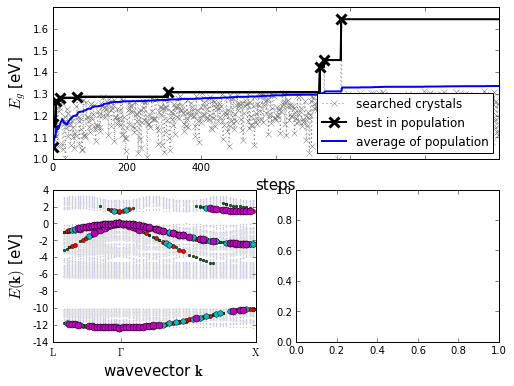

In [12]:
def version2():
    
    out = outs[-1]
    nAl = float(out.molecule.name.split('Ga')[0].replace('Al',''))
    ratio = "%5.3f" % (nAl / 64)
    Eg = "%5.3f" % out.Eg
    
    fig = plt.figure(figsize=(8,6))
    gs = gridspec.GridSpec(2,2)
    ax1 = fig.add_subplot(gs[0,:])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])
    
    weight = '0.9'
    
    stepPlot(ax1, labelsize=15, legendsize=12, search_color='0.5', avg_color='b')
    bandPlot(ax2, out, zero_weight_color=weight, labelsize=15, legendsize=12)
    bandPlot(ax3, outs[-2], zero_weight_color=weight, labelsize=15, legendsize=12)
    
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.set_ylim([1,1.65])
    
    ax3.yaxis.set_label_position('right')
    ax3.yaxis.tick_right()
    
    
    ax3.text(0.0767, 3.9, 
             r'$x=%s, E_g=%s$' % (ratio, Eg),
             bbox={
                 'facecolor':'white', 
                 #'edgecolor':'white',
                 'pad':1.2,
                 #'alpha':.9,
             },
             fontsize=12)
    
    w_list = np.arange(0,1.1,0.2)
    c_list = [weight, 'g', 'r', 'c', 'm']
    for i in range(len(w_list) - 1):
        ax3.plot([10],[0], ls='', marker='o',  
                 markersize=1.5*i + 1, 
                 color=c_list[i],
                 label='%3.1f' % w_list[i+1])
    ax3.legend(numpoints=1, loc=(-0.1,0.05), fontsize=12)
    
    plt.tight_layout(0.5)
    ax1.set_xlim(0, 1000)
    
version2()
plt.savefig('Eg_opt.pdf')

# optmized crystal list

In [7]:
entries_x = opt_log.list(has_data=True, order='descent')[:20]

name_list = []
for e in entries_x:
    coord = np.array(ast.literal_eval(e.content)['mutation'][0])
    #print np.ones(coord.size)[coord == 13].sum()/64, e.data, e.comment
    try:
        name_x = e.comment.split("'")[1]
    except:
        name_x = e.comment
    exist_list = glob.glob('optimization/results/%s' % name_x)
    if len(exist_list) != 1:
        print name_x
    name_list.append(name_x)

In [8]:
step_list = []
for e in entries_x:
    step_list.append([e_all.content for e_all in entries].index(e.content))

In [9]:
weight_list = []
for n in name_list:
    out = qtk.QMOut('optimization/results/%s/%s.out' % (n, n), program='abinit')
    K, E, W = out.unfold([[0.5,0,0.25],[0,0,0],[0,0.5,0.5]], [4,4,4])
    ind = np.argmin(E[E > 0.1])
    w = W[E > 0.1][ind]
    #fig = plt.figure()
    #plt.plot(E, ls='', marker='o')
    weight_list.append(w)

occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption
occupation number not available... try to use molecule object with closed shell assumption

In [10]:
entries_x = opt_log.list(has_data=True, order='descent')[:20]

name_list = []
x_list = []
for i in range(len(entries_x)):
    e = entries_x[i]
    w = weight_list[i]
    s = step_list[i]
    coord = np.array(ast.literal_eval(e.content)['mutation'][0])
    x = np.ones(coord.size)[coord == 13].sum()/64
    x_list.append(x)
    print "%2d & %3d & %6.4f & %7.5f & %4.2f \\\\" % (
        i+1, 
        s,
        e.data, 
        x,
        w * 100,
    )
print "\hline"
print "avg. & - & %6.4f & %7.5f & %4.2f \\\\" % (
        np.mean([e.data for e in entries_x]),
        np.mean(x),
        np.mean(weight_list) * 100,
)

 1 & 818 & 1.5952 & 0.65625 & 50.41 \\
 2 & 415 & 1.5898 & 0.62500 & 62.57 \\
 3 & 812 & 1.5883 & 0.65625 & 49.26 \\
 4 & 525 & 1.5881 & 0.64062 & 59.09 \\
 5 & 225 & 1.5877 & 0.65625 & 53.40 \\
 6 & 604 & 1.5873 & 0.60938 & 50.42 \\
 7 & 679 & 1.5870 & 0.62500 & 53.67 \\
 8 & 471 & 1.5856 & 0.65625 & 58.86 \\
 9 & 377 & 1.5853 & 0.65625 & 46.78 \\
10 &  38 & 1.5850 & 0.59375 & 59.94 \\
11 & 834 & 1.5841 & 0.60938 & 5.49 \\
12 & 969 & 1.5832 & 0.65625 & 54.22 \\
13 & 557 & 1.5828 & 0.67188 & 53.17 \\
14 & 507 & 1.5825 & 0.60938 & 52.37 \\
15 & 968 & 1.5819 & 0.62500 & 57.98 \\
16 & 847 & 1.5799 & 0.59375 & 54.50 \\
17 & 545 & 1.5791 & 0.62500 & 59.17 \\
18 & 264 & 1.5791 & 0.62500 & 59.69 \\
19 & 676 & 1.5789 & 0.62500 & 57.48 \\
20 & 838 & 1.5789 & 0.62500 & 54.82 \\
\hline
avg. & - & 1.5845 & 0.62500 & 52.66 \\


In [32]:
for i in range(len(outs_true)):
    if hasattr(outs_true[i], 'band'):
        out_true = outs_true[i]
        out_pred = outs[i]

(array([ 0.03880517,  0.03880517,  0.03880517, ...,  0.17121195,
         0.12441115,  0.17121195]),
 array([-12.11192848, -12.08994167, -11.77379967, ...,   2.81874689,
          2.84892433,   2.84892433]),
 array([  1.10630000e-02,   9.76000000e-04,   2.03353000e-01, ...,
          2.45400000e-03,   1.30107000e-01,   1.40000000e-04]))

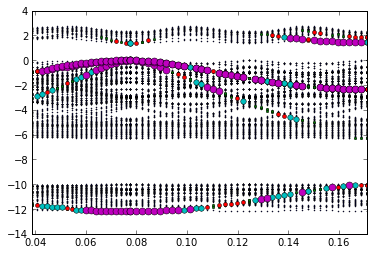

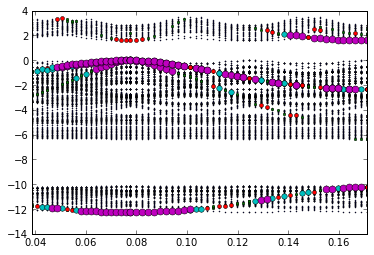

In [33]:
out_true.plot_band_unfold([[0.5,0,0.25],[0,0,0],[0,0.5,0.5]], [4,4,4])
out_pred.plot_band_unfold([[0.5,0,0.25],[0,0,0],[0,0.5,0.5]], [4,4,4])

In [30]:
out_true.band - out_pred.band

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [34]:
out_true.Eg

1.3755360744725991